In [12]:
# from google.colab import drive
# import pathlib
# drive.mount('/content/drive')
# dataset_folder = "/content/drive/My Drive/cs182_project/code/tiny-imagenet-200/"
# root_folder = "/content/drive/My Drive/cs182_project/code"
# data_dir = pathlib.Path(dataset_folder)
# drive.flush_and_unmount()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!curl http://cs231n.stanford.edu/tiny-imagenet-200.zip -O tiny-imagenet-200.zip
!unzip tiny-imagenet-200.zip

In [5]:
from __future__ import print_function, division

# import sys
# sys.path.append(root_folder)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pathlib
plt.ion()   # interactive mode

In [6]:
dataset_folder = "/content/tiny-imagenet-200/"
data_dir = pathlib.Path(dataset_folder)

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [7]:
image_datasets = {x: datasets.ImageFolder(data_dir / x, data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [9]:
IDX_TO_CLASS = []
with open("/content/tiny-imagenet-200/wnids.txt") as f:
    for line in f:
        IDX_TO_CLASS.append(line.strip())
f.close()

CLASS_TO_LABEL = {}
with open("/content/tiny-imagenet-200/words.txt") as f:
    for line in f:
        (key, val) = line.split('\t')
        vals = val.strip().split(',')
        CLASS_TO_LABEL[key] = vals[0]
f.close()

def indexToClass(idx):
    return IDX_TO_CLASS[idx]

def classToLabel(class_name):
    return CLASS_TO_LABEL[class_name]

def indexToLabel(idx):
    class_name = indexToClass(idx)
    return classToLabel(class_name)

def num_classes():
    return len(IDX_TO_CLASS)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


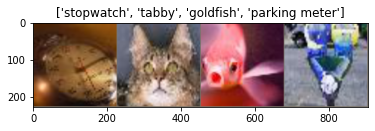

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[classToLabel(class_names[x]) for x in classes])

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_total = 0

            # Iterate over data.
            counter = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    if counter > 0 and counter % 100 == 0:
                      print("Iteration: {} out of {} with Loss: {:.4f} and Accuracy: {:.4f}".format(counter, len(dataloaders['train']), loss, torch.sum(preds == labels.data) / torch.sum(preds)))

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                running_total += torch.sum(preds)
                counter += 1
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [12]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [13]:
model_conv = torchvision.models.resnet101(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


In [73]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Iteration: 100 out of 25000 with Loss: 5.0187 and Accuracy: 0.0000
Iteration: 200 out of 25000 with Loss: 5.6506 and Accuracy: 0.0000
Iteration: 300 out of 25000 with Loss: 5.2891 and Accuracy: 0.0000


KeyboardInterrupt: ignored

In [14]:
def naive_train(model, optim, criterion, train_loader, num_epochs):
  for i in range(num_epochs):
        train_total, train_correct = 0,0
        for idx, (inputs, targets) in enumerate(train_loader):
            optim.zero_grad()
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optim.step()
            _, predicted = outputs.max(1)
            train_total += targets.size(0)
            train_correct += predicted.eq(targets).sum().item()
            print("\r", end='')
            print(f'training {100 * idx / len(train_loader):.2f}%: {train_correct / train_total:.3f}', end='')
        print("Epoch {} completed with overall accuracy at {:.4f}".format(i, train_correct / train_total))
        torch.save({
            'net': model.state_dict(),
        }, 'latest.pt')

In [ ]:
model_conv = naive_train(model_conv, optimizer_conv, criterion, dataloaders['train'], num_epochs=25)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


training 41.55%: 0.098